In [ ]:
%%HTML
<!-- Make fonts readable at 1024x768 -->
<style>
.rendered_html { font-size:0.5em; }
</style>

In [1]:
# Imports and matplotlib configuration
import numpy as np
import scipy.signal
%matplotlib notebook
import matplotlib.pylab as plt
from matplotlib import animation, rcParams
from ipywidgets import interact, FloatSlider, IntSlider, SelectionSlider, Layout, Button, Output, Box
from IPython.display import display, Audio, HTML
import soundfile as sf

# Default options for matplotlib plots
rcParams['figure.dpi'] = 80
rcParams['font.size'] = 14
rcParams['axes.grid'] = True
rcParams['lines.linewidth'] = 2.0
rcParams['legend.framealpha'] = 0.5
rcParams['legend.fontsize'] = 'medium'
rcParams['figure.titlesize'] = 'medium'
rcParams['figure.autolayout'] = True
# rcParams['animation.html'] = 'html5'
slider_layout = Layout(width='600px', height='20px')
slider_style = {'description_width': 'initial'}
from functools import partial
FloatSlider_nice = partial(FloatSlider, style=slider_style, layout=slider_layout, continuous_update=False)
IntSlider_nice = partial(IntSlider, style=slider_style, layout=slider_layout, continuous_update=False)
SelectionSlider_nice = partial(SelectionSlider, style=slider_style, layout=slider_layout, continuous_update=False)

# Optional: Set options for slide theme and transition
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/phuijse/.jupyter/nbconfig/"
cm = BaseJSONConfigManager(config_dir=path)
cm.update('livereveal', {
    'theme': 'simple',
    'transition': 'fast',
    'start_slideshow_at': 'selected',
    'width': 1024,
    'height': 768,
    'scroll': True,
    'center': False
});

### Universidad Austral de Chile 
## INFO183: Análisis de sistemas lineales


# Unidad 2: Herramientas de análisis de señales

### Dr. Pablo Huijse, phuijse at inf dot uach dot cl 

### <a href="https://github.com/phuijse/UACH-INFO183"> github.com/phuijse/UACH-INFO183 </a>


# Contenidos de la unidad

1. [Representación por serie de Fourier](#section1)
1. [Transformada de Fourier](#section2)
1. Principio de incertidumbre
1. Transformada de Fourier discreta (DFT) y sus propiedades
1. Efectos del muestreo y del enventanado
1. Transformada rápida de Fourier (FFT)
1. Espectrograma con Transformada de Fourier short-time
1. Detección y comparación de señales
1. Autocorrelación y correlación cruzada
1. Espectro de potencia y periodograma
1. Teorema de Wiener-Khinchin
1. Detección de señales con Match filter
1. Limpieza de señales con filtro de Wiener


<a id="section1"></a>

# Espectro

- Isaac Newton llamó **espectros** a los componentes que forman la luz blanca y que normalmente no se pueden ver
- Newton mostró usando prismas que la luz blanca pueden descomponerse en colores y viceverza
- Hoy entendemos que la luz como onda tiene una frecuencia asociada y que cada color es una frecuencia particular


| <img src="img/fourier-newton.jpg">  | <img src="img/fourier-prism.jpg" width="75%">  |
|:-:|:-:|

- Paradojicamente, Newton nunca acepto que esto se debía a la frecuencia de la radiación ya que creía en la teoría corpuscular de la luz


## Onda

- Es una perturbación que transporta energía a través del espacio
- Es una oscilación o vibración de un medio físico o campo
- Se describe (tipicamente) por su frecuencia (período), amplitud y desfase

**Onda electromagnética** 
- Oscilaciones en el campo eléctrico y magnético
- Transporta energía electromágnetica radiativa
- Dependiendo de su frecuencia se clasifican como:
<img src="img/fourier-colors.jpg">

## Componentes frecuenciales y harmónicos

- Una sinusoide es una función del tiempo completamente descrita por su amplitud $A$, frecuencia $f$ y fase $\phi$

$$
s(t) = A \cos (2 \pi f t + \phi)
$$

*Ejercicio:* Explique intuitivamente como estos parámetros afectan a $s(t)$ 

- El recíproco de la frecuencia es el período $P= \frac{1}{f}$
- Notemos que una señal que es períodica en $\frac{P}{k} ~ \forall k \in \mathbb{N}$ también lo es en $P$
- Llamamos a $f=1/P$ la **frecuencia fundamental**
- Llamamos a $f_k = kf = k/P ~~ \forall k \in \mathbb{N}$ el **k-esimo armónico de $f$**

<IPython.core.display.Javascript object>


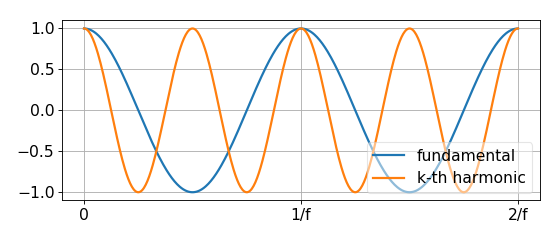

interactive(children=(SelectionSlider(continuous_update=False, description='k', layout=Layout(height='20px', w…

In [3]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 3))
f = 1.51518
t = np.linspace(0, 2/f, num=500); x = np.cos(2.0*np.pi*f*t)
ax.plot(t, x, label='fundamental')
line = ax.plot(t, x, label='k-th harmonic'); ax.legend(loc=4)
ax.set_xticks([0, 1/f, 2/f]); ax.set_xticklabels(["0", "1/f", "2/f"]);
update = lambda k: line[0].set_ydata(np.cos(2.0*np.pi*t*f*k))
interact(update, k=SelectionSlider_nice(options=[2, 3, 4, 5, 6]));

- Si sumamos dos sinusoides con amplitudes arbitrarias pero con igual frecuencia fundamental $f$ [Hz], la suma también es periódica con fundamental $f$ [Hz]
- La suma puede ser una señal periódica arbitraria (no trigonométrica)

<IPython.core.display.Javascript object>


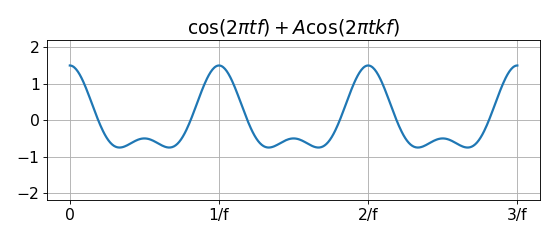

interactive(children=(SelectionSlider(continuous_update=False, description='k', layout=Layout(height='20px', w…

In [4]:
plt.close('all'); fig, ax = plt.subplots(figsize=(7, 3))
f = 1.51518
t = np.linspace(0, 3/f, num=500); x = np.cos(2.0*np.pi*f*t)
line = ax.plot(t, 2*x)
ax.set_xticks([0, 1/f, 2/f, 3/f]); ax.set_xticklabels(["0", "1/f", "2/f", "3/f"]);
ax.set_title(r"$\cos(2\pi t f) + A \cos(2\pi t k f)$")
update = lambda k, A: line[0].set_ydata(x + A*np.cos(2.0*np.pi*t*f*k))
interact(update, k=SelectionSlider_nice(options=[2, 3, 4, 5, 6]), 
         A=FloatSlider_nice(min=0.5, max=1.0, value=0.5));

- Dependiendo de los armónicos que incorporemos podemos reproducir distintas señales periódicas

<IPython.core.display.Javascript object>


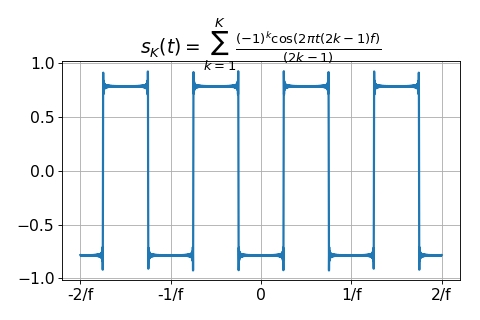

interactive(children=(SelectionSlider(continuous_update=False, description='K', layout=Layout(height='20px', w…

In [5]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(-2/f, 2/f, num=5000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([-2/f, -1/f, 0, 1/f, 2/f]); 
ax.set_xticklabels(["-2/f", "-1/f", "0", "1/f", "2/f"]);
ax.set_title(r"$s_K(t) = \sum_{k=1}^K \frac{(-1)^k \cos(2\pi t (2k-1) f)}{(2k-1)}$")
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        y += np.cos(2.0*np.pi*(2*k-1)*f*t)/(2*k-1)*(-1)**k
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

<IPython.core.display.Javascript object>


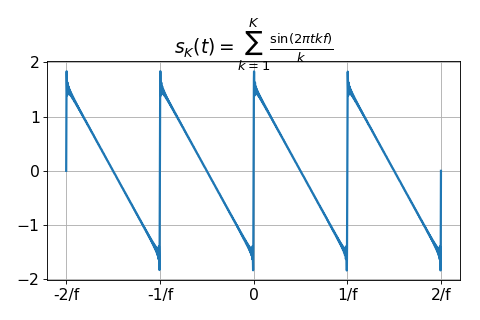

interactive(children=(SelectionSlider(continuous_update=False, description='K', layout=Layout(height='20px', w…

In [6]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(-2/f, 2/f, num=5000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([-2/f, -1/f, 0, 1/f, 2/f]); 
ax.set_xticklabels(["-2/f", "-1/f", "0", "1/f", "2/f"]);
ax.set_title(r"$s_K(t) = \sum_{k=1}^K \frac{\sin(2\pi t k f)}{k}$")
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        y += np.sin(2.0*np.pi*k*f*t)/k
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

- Las funciones coseno y seno son par e impar, respectivamente
- ¿Cómo podemos construir una señal periódica que no es par ni impar?
- Consideremos la siguiente forma general
\begin{align}
s(t) &= \sum_{k=0}^\infty A_k \cos(2\pi k f t + \phi_k) \nonumber \\
&= \sum_{k=0}^\infty a_k \cos(2\pi k f t) + b_k \sin(2\pi k f t),
\end{align}
donde $a_k = A_k \cos(\phi_k)$ y $b_k = -A_k \sin(\phi_k)$ se obtienen de $\cos(x+y) = \cos(x)\cos(y) - \sin(x)\sin(y)$
- De esta forma $s(t)$ puede ser cualquier función real periódica con período $P=1/f$
- Esto se conoce como **serie trigonométrica** 

<IPython.core.display.Javascript object>


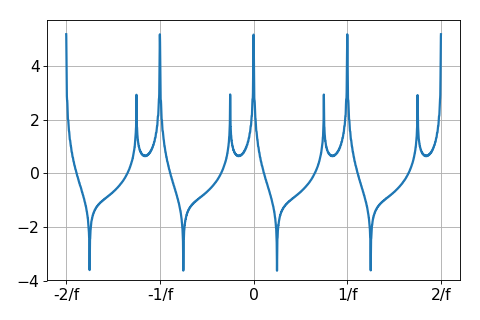

interactive(children=(SelectionSlider(continuous_update=False, description='K', layout=Layout(height='20px', w…

In [7]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(-2/f, 2/f, num=5000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([-2/f, -1/f, 0, 1/f, 2/f]); 
ax.set_xticklabels(["-2/f", "-1/f", "0", "1/f", "2/f"]);
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        y += np.cos(2.0*np.pi*k*f*t)/k + (-1)**k*np.sin(2.0*np.pi*(2*k-1)*f*t)/(2*k-1)
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

### Apéndice: Números complejos

Sea z un número complejo, lo podemos escribir en forma cartesiana 
$$
z = \Re[z] + j \Im[z] = a + j b
$$
donde $a \in \mathbb{R}$, $b \in \mathbb{R}$ y $j = \sqrt{-1}$ es el número imaginario.


También podemos escribirlo en forma polar
$$
z = c e^{j\phi} = c \cos(\phi) + j c \sin(\phi)
$$
donde 
- $c = |z| = \sqrt{a^2 + b^2} \in [0, \infty]$ es la magnitud 
- $\phi = \angle z = \tan^{-1} \left (\frac{b}{a} \right) \in [-\frac{\pi}{2}, \frac{\pi}{2}]$ es el ángulo
- $a = c \cos(\phi)$
- $b = c\sin(\phi)$

se pueden escribir las siguientes relaciones 

$$
\cos(\phi) = \frac{1}{2} (e^{j\phi} + e^{-j\phi}) ~\wedge~ \sin(\phi) = \frac{1}{2j} (e^{j\phi} - e^{-j\phi})
$$

el complejo conjugado de $z = a + j b = c e^{j\phi}$ es
$$
z^* = a - jb = c e^{-j\phi}
$$

<IPython.core.display.Javascript object>


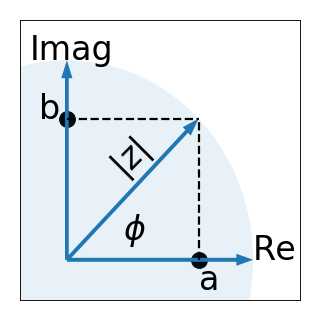

In [8]:
from matplotlib import patches
plt.close('all'); fig, ax = plt.subplots(figsize=(4, 4))
my_arrow = partial(ax.arrow, x=0, y=0, width=0.02, length_includes_head=True, linewidth=0)
my_arrow(dx=np.sqrt(0.5), dy=np.sqrt(0.5)); my_arrow(dx=1, dy=0); my_arrow(dx=0, dy=1)
ax.text(x=-0.2, y=1.0, s="Imag", fontsize=30); ax.text(x=1.0, y=-0.0, s="Re", fontsize=30);
ax.text(x=-0.15, y=np.sqrt(0.5), s="b", fontsize=30); ax.text(x=np.sqrt(0.5), y=-.15, s="a", fontsize=30);
ax.text(x=0.2, y=0.5, s="$|z|$", fontsize=30, rotation=45.); ax.text(x=0.3, y=0.1, s="$\phi$", fontsize=30);
ax.plot([0, np.sqrt(0.5)], [np.sqrt(0.5), np.sqrt(0.5)],'k--');
ax.plot([np.sqrt(0.5), np.sqrt(0.5)], [0, np.sqrt(0.5)],'k--')
p = patches.Circle(xy=(0, 0), radius=1, alpha=0.1); ax.set_xticks([]); ax.set_yticks([])
ax.scatter([0, np.sqrt(0.5)], [np.sqrt(0.5), 0], c='k', s=200);
ax.add_artist(p); plt.xlim([-0.25 , 1.25]); plt.ylim([-0.2 , 1.2]);

# Serie de Fourier

- En 1807 *Jean Baptiste Joseph Fourier* presenta un teorema indicando que una función periódica arbitraria con periódo $P=1/f$ puede representarse como una suma ponderada de senos y cosenos
- La serie de Fourier (FS) para una función compleja se define como
$$
s(t) = \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi kf t}, ~~ c_k \in \mathbb{C}
$$


La serie trigonométrica es el caso particular de la FS para una función real
\begin{align}
s(t) &= \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi kf t} \nonumber \\
&= \sum_{k=1}^{\infty} c_{-k} e^{-j 2\pi kf t} + c_0 + \sum_{k=1}^{\infty} c_{k} e^{j 2\pi kf t} \\
&= \sum_{k=1}^{\infty} \left(c_{k} e^{j 2\pi kf t}\right)^* + c_0 + \sum_{k=1}^{\infty} c_{k} e^{j 2\pi kf t} \\
&= c_0 + 2 \sum_{k=1}^{\infty} \Re [ c_{k} e^{j 2\pi kf t} ]\\
&= \sum_{k=0}^{\infty} A_k \cos({j 2\pi kf t + \phi_k} )\\
\end{align}
en la última equivalencia reconocemos
$$
c_k = \begin{cases}  \frac{1}{2} A_k e^{j\phi_k} & k> 0 \\ A_0 & k = 0 \\ c_{|k|}* & k < 0\end{cases}
$$

### Apéndice: Bases generadoras
 - Una base es un conjunto de un espacio vectorial
 - Los elementos de la base son linealmente independientes
 - Todos los elementos del espacio pueden expresarse como una combinación lineal de la base
 
Considere el espacio vectorial $\mathbb{R}^3$. El siguiente conjunto 

$$
\left \{ v_1=\begin{pmatrix} 1 \\ 0 \\ 0 \end{pmatrix}, v_2= \begin{pmatrix} 0 \\ 1 \\ 0 \end{pmatrix}, v_3=\begin{pmatrix} 0 \\ 0 \\ 1 \end{pmatrix}\right \},
$$

es una base generadora de $\mathbb{R}^3$, es decir un vector cualquiera $\vec a = (a_1, a_2, a_3) \in \mathbb{R}^3$ se puede representar como 

$$
\vec a = a_1 v_1 + a_2 v_2 + a_3 v_3.
$$

Un conjunto ortonormal siempre es linealmente independiente

## Base de Fourier

El conjunto de funciones 

$$
v_k (t) = \frac{1}{\sqrt{P}} e^{j2\pi k t / P} ~~ \forall k \in \mathbb{Z}
$$

cumple 

$$
\langle v_n (t), v_m (t) \rangle = \int_0^P v_n (t) v_m^* (t) dt = \frac{1}{P} \int_0^P e^{j2\pi (n-m)t/P} dt =\begin{cases}1 & n=m \\ 0 & n \neq m\end{cases}
$$

*i.e.* es un conjunto ortonormal (l.i.) en el espacio de funciones periódicas con periódo $P$

Esto es facilmente comprobable si estudiamos

$$
\int_0^P e^{j2\pi k t / P} dt = \int_0^P \cos(2\pi k t/P) dt + j \int_0^P \sin(2\pi k t/P) dt 
$$

<IPython.core.display.Javascript object>


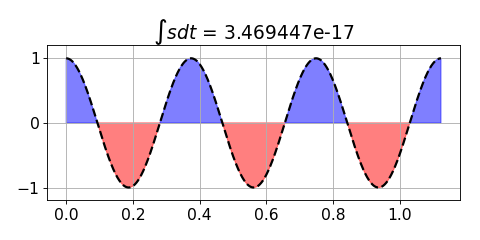

interactive(children=(IntSlider(value=1, continuous_update=False, description='k', layout=Layout(height='20px'…

In [28]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 3))
dt=1e-4; P=1.1234; t = np.arange(0, P, step=dt);
line = ax.plot(t, np.zeros_like(t)); ax.set_ylim([-1.2, 1.2])
harmonic = lambda k: np.cos(2.0*np.pi*k*t/P)
def update(k):
    ax.cla(); ax.set_ylim([-1.2, 1.2])
    ax.plot(t, harmonic(k), 'k--')
    ax.fill_between(t, 0, harmonic(k), harmonic(k)>0, color='b', alpha=0.5)
    ax.fill_between(t, 0, harmonic(k), harmonic(k)<0, color='r', alpha=0.5)
    ax.set_title("$\int s dt$ = %e" %(np.sum(harmonic(k)*dt)))
interact(update, k=IntSlider_nice(min=0, max=10, value=1));

propiedad generadora?

### Síntesis

$$
s(t) = \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi k t/P} 
$$

### Análisis

\begin{align}
\langle s(t),  e^{j 2\pi m t/ P} \rangle &= \int_0^P s(t) e^{-j 2\pi m t/ P} dt \nonumber \\
&= \int_0^P \sum_{k=-\infty}^{\infty} c_k e^{j 2\pi k t/P} e^{-j 2\pi m t/P} dt \nonumber \\
&= \sum_{k=-\infty}^{\infty} c_k  \int_0^P e^{j 2\pi (k-m) t/P}  dt \nonumber \\
&=  c_m  P \nonumber \\
\end{align}

Es decir los coeficientes de la FS se pueden encuentrar usando

$$
c_m = \frac{1}{P} \int_0^P s(t) e^{-j 2\pi m t/P} dt
$$

### Ejemplo: FS de señal cuadrada

Sea 
$$
s(t) = \begin{cases} 1 & t \in[0, \frac{P}{2}] \\ -1 & t \in [\frac{P}{2}, P] \end{cases}
$$
Los coeficientes de su FS son
$$
c_0 = \frac{1}{P} \int_0^P s(t) dt = 0
$$

\begin{align}
c_k &= \frac{1}{P} \int_0^\frac{P}{2} e^{-j2\pi kt/P} dt  - \frac{1}{P}  \int_\frac{P}{2}^P e^{-j2\pi kt/P} dt  \nonumber \\  
&= \frac{1 - e^{j\pi k}}{P} \int_0^\frac{P}{2} e^{-j2\pi kt/P} dt \nonumber \\
&=  \frac{1 - (-1)^k}{j \pi k} \nonumber \\
\end{align}

Notemos que los coeficientes 
- sólo tienen parte imaginaria
- sólo son distintos de cero para armónicos impares

<IPython.core.display.Javascript object>


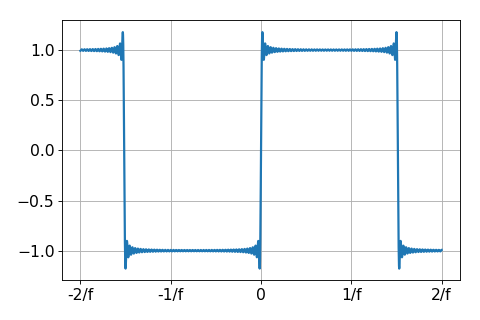

interactive(children=(SelectionSlider(continuous_update=False, description='K', layout=Layout(height='20px', w…

In [26]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
f = 1.51518; t = np.linspace(-2/f, 2/f, num=5000); 
line = ax.plot(t, np.zeros_like(t))
ax.set_xticks([-2/f, -1/f, 0, 1/f, 2/f]); 
ax.set_xticklabels(["-2/f", "-1/f", "0", "1/f", "2/f"]);
def update(K):
    y = np.zeros_like(t)
    for k in range(1, K+1):
        y += 2*(1-(-1)**k)*np.sin(2.0*np.pi*t*k/P)/(np.pi*k)
    line[0].set_ydata(y); ax.set_ylim([np.amin(y)*1.1, np.amax(y)*1.1])
interact(update, K=SelectionSlider_nice(options=[1, 2, 3, 4, 5, 10, 20, 30, 50, 100]));

<IPython.core.display.Javascript object>


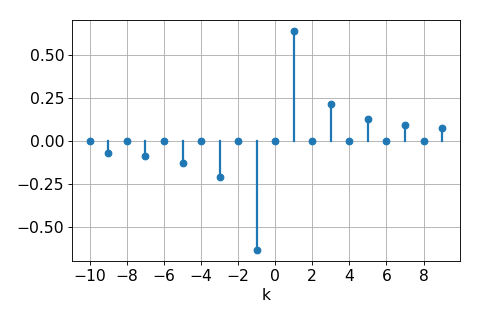

In [27]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 4))
k = np.arange(-10, 10, step=1).astype('float')
ax.stem(k, (1-(-1)**k)/(np.pi*k+1e-10), basefmt=" ")
ax.set_xticks(range(-10, 10, 2)); ax.set_xlabel("k");

## Propiedades

- Si $s(t)$ es par entonces $c_k$ es par
- Si $s(t)$ es impar entonces $c_k$ es impar
- Si $s(t + P/2) = -s(t)$ (antiperiódica) entonces $c_k=0 $ para k par
- Si $s(t)$ es real y par entonces $c_k$ es real y par
- Si $s(t)$ es real e impar entonces $c_k$ es imaginario e impar
- Una señal antisimétrica/impar sólo tiene componentes imaginarios
- La FS es lineal
- **Teorema de Parseval:** La potencia de una señal puede calcularse a partir de sus compoenentes
$$
E_s = \frac{1}{P} \int_0^P |s(t)|^2 dt = \sum_{k=-\infty}^\infty |c_k|^2
$$

Visualización interactiva de la FS: https://bl.ocks.org/jinroh/7524988

## Convergencia de la serie de Fourier (Oppenheim, SS, Chap 3.4)

Para una serie periódica con periódo $P$, si
1. Es absolutamente integrable: $\int_0^P |s(t)| dt < \infty$
1. Tiene un número finito de extremos
1. Tiene un número finito de discontinuidades

entonces su FS converge para todo tiempo, excepto en las discontinuidades donde converge al punto medio.


- Estos tres puntos se conocen como **Condiciones de Dirichlet**
- **Fenomeno de Gibbs:** Una discontinuidad requiere ancho de banda infinito, por ende no puede reproducirse con un número finito de términos (vea el ejemplo de la señal cuadrada)

<a id="section2"></a>

# Transformada de Fourier

- El concepto de frecuencia puede aplicarse también a señales no-periódicas
- **Joseph Fourier:** Una señal no-periódica puede ser vista como una señal periódica con un período infinito
- El único requisito es que ahora las frecuencias son un continuo, con un espaciado infinitesimal
- Una señal analógica puede ser vista como continua en el tiempo o continua en frecuencia
- Para señales digitales estudiaremos la Transformada de Fourier discreta (DFT)

Sea un pulso cuadrado con periódo P y ancho $2T < P$ definido en un período como

$$
s(t) = \begin{cases} 1, & |t| < T \\ 0, & T<|t| < P/2 \end{cases}
$$

<IPython.core.display.Javascript object>


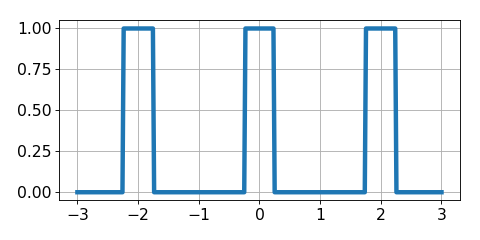

In [124]:
plt.close('all'); fig, ax = plt.subplots(figsize=(6, 3))

def create_square_pulse(t, T=0.25, P=2):
    s = np.zeros_like(t)
    for k in np.unique(t//P):
        s[(t> k*P - T) & (t< k*P + T)] = 1
    return s

t = np.linspace(-3, 3, num=300)
ax.plot(t, create_square_pulse(t), linewidth=4);

Su serie de Fourier es 
$$
c_0 = \frac{1}{P} \int_{-P/2}^{P/2} s(t) dt = \frac{1}{P} \int_{-T}^{T}  dt = \frac{2T}{P}
$$

\begin{align}
c_k &= \frac{1}{P} \int_{-T}^{T} e^{-j2\pi kt/P} dt  \\
&= \frac{1}{\pi k} \sin \left (2\pi k \frac{T}{P} \right) 
\end{align}

¿Qué ocurre a medida que P crece?


<IPython.core.display.Javascript object>


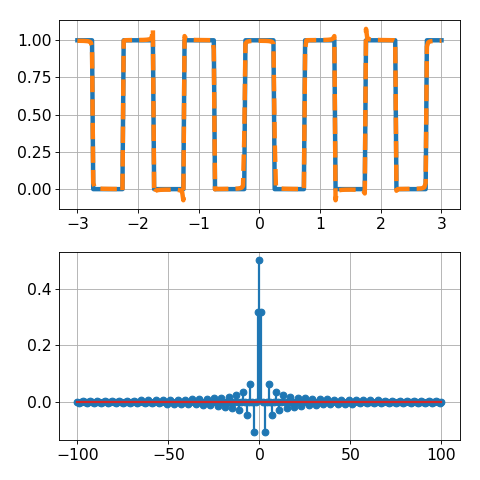

interactive(children=(IntSlider(value=1, continuous_update=False, description='P', layout=Layout(height='20px'…

In [125]:
plt.close('all'); fig, ax = plt.subplots(2, 1, figsize=(6, 6))

def update(P, show_envelope=False):
    ax[0].cla(); ax[1].cla(); T=0.25
    s = create_square_pulse(t, T=T, P=P)
    xhat = np.zeros_like(t) + 2*T/P
    ck = np.zeros(shape=(201, )); ck[100] = 2*T/P
    ck[101:] = np.array([np.sin(2.0*np.pi*k*T/P)/(np.pi*k) for k in range(1, 101)])
    ck[:100] = ck[101:][::-1]
    for k in range(1, 100):
        xhat += 2*np.cos(2.*np.pi*t*k/P)*ck[100+k]
    ax[0].plot(t, s, linewidth=4); ax[0].plot(t, xhat, linestyle='--', linewidth=4);
    f_axis = np.linspace(-100/P, 100/P, num=len(ck))
    ax[1].stem(f_axis, P*ck); 
    if show_envelope:
        ax[1].plot(f_axis, 2*T*np.sinc(2*f_axis*T), 'k-', linewidth=4, alpha=0.75);
interact(update, P=IntSlider_nice(min=1, max=15));

¿Qué ocurrio en el ejemplo que vimos?
- A mayor P disminuye la frecuencia fundamental
- Cuando P es muy grande podemos considerar el tren de pulsos como un único pulso
- A mayor P los coeficientes de la serie de Fourier muestrean con más fineza la envolvente
- ¿A qué corresponde la envolvente en este caso?

La envolvente es una función de la frecuencia $f=kf_0 = k/P$, se obtiene cuando $P\to \infty$ y se define como

$$
S(f) = P c_k = \int_{-\infty}^{\infty} s(t) e^{-j 2\pi t  f} dt,
$$

o también

$$
S(\omega) = \int_{-\infty}^{\infty} s(t) e^{-j\omega t } dt,
$$

donde $\omega = 2\pi f$ se llama frecuencia angular.

La envolvente se conoce como **transformada de Fourier directa** o **integral de Fourier**.

Reemplazando el resultado anterior en la ecuación de síntesis tenemos que

\begin{align}
s(t) &= \lim_{f_0 \to 0} \sum_{k=-\infty}^{\infty} f_0 S(k f_0) e^{j 2\pi t  k f_0} \\
&= \int_{-\infty}^{\infty} S(f) e^{j 2\pi t  f} df \\
&= \frac{1}{2\pi} \int_{-\infty}^{\infty} S(\omega) e^{j \omega t } d\omega,
\end{align}

que se conoce como **transformada de Fourier inversa**.


## Par de Fourier

Directa:
$$
S(\omega) = \int_{-\infty}^{\infty} s(t) e^{-j\omega t } dt,
$$

Inversa:
$$
s(t) = \frac{1}{2\pi} \int_{-\infty}^{\infty} S(\omega) e^{j \omega t } d\omega,
$$

### Ejemplo: Transformada de Fourier de un pulso cuadrado

\begin{align}
S(\omega) &= \int_{-\infty}^{\infty} s(t) e^{-j\omega t } dt \\
&= \int_{-T}^{T} e^{-j\omega t } dt \\
&= \frac{1}{-j\omega} \left(e^{-j\omega T }  - e^{j\omega T } \right)\\
&= \frac{2}{\omega}  \sin(\omega T) = 2T \text{sinc}(\omega T)\\
\end{align}